In [1]:
import matplotlib.pyplot as plt
import json
from run import run as run_lca
from run_baseline import run as run_baseline
from tools import *
from init_logger import init_logger
import os
import ga_driver
import numpy as np
import exp_scores as es
import gamma_scores as gs
import bayesian_scores as bs
import extexp_scores as ees
import logistic_scores
import isotonic_scores
from kernel_density_scores import kernel_density_scores

%load_ext autoreload
%autoreload 2

In [2]:
import weighter

config = get_config("configs/config_spermwhale.yaml")
lca_config = config['lca']
db_path = os.path.join(lca_config['db_path'], config['exp_name'])

verifier_file =  os.path.join(db_path, "verifiers_probs.json")
wgtrs_calib_dict = load_json(verifier_file)
lca_config['logging']['log_file'] = None
lca_params = generate_ga_params(lca_config)
probs = wgtrs_calib_dict['miewid']
# wgtrs = ga_driver.generate_weighters(
#             lca_params, wgtrs_calib_dict
#         )
exp_scorer = es.exp_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )
gamma_scorer = gs.gamma_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )

pos_scores = probs["gt_positive_probs"]
neg_scores = probs["gt_negative_probs"]

# wgtr = wgtrs[0]#weighter.weighter(gamma_scorer, config["lca"]["edge_weights"]['prob_human_correct'])

In [3]:
verifier_file

'tmp/spermwhale_encounters_kde_full/verifiers_probs.json'

In [4]:
from tools import load_json, load_pickle

exp_name = config['exp_name']

initial_edges = load_json(f"/ekaterina/work/src/lca/lca/tmp/initial_edges_{exp_name}.json")

print(len(initial_edges))


pos = [s for (a0, a1, s, w, c) in initial_edges if c]
neg = [s for (a0, a1, s, w, c) in initial_edges if not c]

pos_weights = [w/10 for (a0, a1, s, w, c) in initial_edges if c]
neg_weights = [w/10 for (a0, a1, s, w, c) in initial_edges if not c]

14868


In [5]:
np.array(initial_edges).shape

(14868, 5)

In [6]:
needed_total = 200
min_samples_from_bin = 1
max_samples_from_bin = 50


num_bins = 100
scores = [s for _, _, s,_, _ in initial_edges]
min_score = min(scores)
max_score = max(scores)
delta_score = (max_score - min_score) / (num_bins-1)
bins = [[] for _ in range(num_bins)]
for n0, n1, s, w, c in initial_edges:
    i = int((s - min_score) / delta_score)
    bins[i].append((n0, n1, s, w, c))

logger = logging.getLogger('lca')
logger.info(f"Bin sizes: {[len(b) for b in bins]}")

# 2. Shuffle each bin
pos_triples = []
neg_triples = []
# 3. Pull edges from the bins
for i in range(len(bins)):
    batch_sz = np.clip(int(needed_total * len(bins[i])/len(scores)), min_samples_from_bin, len(bins[i]))
    rnd_edges = [bins[i][j] for j in np.random.choice(len(bins[i]), batch_sz, replace=False)]
    for e in rnd_edges:
        if e[-1]:
            pos_triples.append(e)
        else:
            neg_triples.append(e)

print(len(pos_triples))
print(len(neg_triples))

41
151


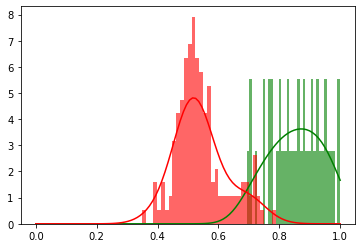

In [7]:
plt.hist([s for (_, _, s, _, _) in pos_triples], bins=35, density=True, alpha=0.6, color='g')
plt.hist([s for (_, _, s, _, _) in neg_triples], bins=35, density=True, alpha=0.6, color='r')

scorer = kernel_density_scores.create_from_samples(
            [s for (_, _, s, _, _) in pos_triples], [s for (_, _, s, _, _) in neg_triples]
        )
# scorer = kernel_density_scores.create_from_samples(
#             pos, neg
#         )
xs = np.linspace(0, 1, 100)
wgtr = weighter.weighter(scorer, config["lca"]["edge_weights"]['prob_human_correct'])
pos_ys = [wgtr.scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [wgtr.scorer.get_pos_neg(x)[1] for x in xs]
plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')

plt.show()

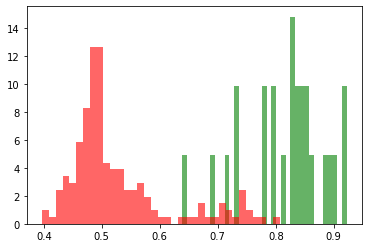

In [8]:


edges_low = [(a0, a1, s, w, c) for (a0, a1, s, w, c) in initial_edges if s < 0.5]
edges_high = [(a0, a1, s, w, c) for (a0, a1, s, w, c) in initial_edges if s >= 0.5]

rnd_edges_low = [edges_low[i] for i in np.random.choice(len(edges_low), 100, replace=False)]
rnd_edges_high = [edges_high[i] for i in np.random.choice(len(edges_high), 100, replace=False)]

rnd_edges = rnd_edges_low + rnd_edges_high

pos_h = [s for (a0, a1, s, w, c) in rnd_edges if c]
neg_h = [s for (a0, a1, s, w, c) in rnd_edges if not c]

plt.hist(pos_h, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg_h, bins=35, density=True, alpha=0.6, color='r')
plt.show()

In [9]:
wgtr = load_pickle(f"/ekaterina/work/src/lca/lca/tmp/wgtr_{exp_name}.pickle")

In [10]:
def remove_outliers(scores, sign=1, std_mult=1.5):
    # scores = np.array([s for (_, _, s) in pairs])
    if sign < 0:
        filter = scores - np.mean(scores) > std_mult * np.std(scores)
    else:
        filter = np.mean(scores) - scores > std_mult * np.std(scores)
    # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
    return np.array(scores)[np.logical_not(filter)], np.array(scores)[filter]

pos_scores_filtered, pos_outliers = remove_outliers(pos_scores,  1)
neg_scores_filtered, neg_outliers = remove_outliers(neg_scores, -1)

Text(0.5, 1.0, 'Spermwhale')

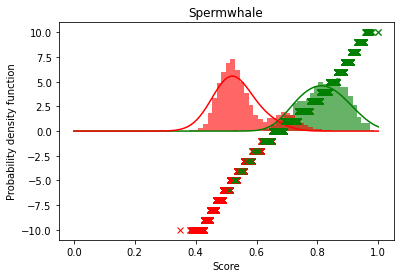

In [11]:


# plt.hist(pos_scores_filtered, bins=35, density=True, alpha=0.6, color='g')
# plt.hist(neg_scores_filtered, bins=35, density=True, alpha=0.6, color='r')
plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
# plt.hist(probs['gt_negative_probs'], bins=35, density=True, alpha=0.6, color='r')
# plt.hist(probs['gt_positive_probs'], bins=35, density=True, alpha=0.6, color='g')
xs = np.linspace(0, 1, 100)

# scorer = kernel_density_scores.create_from_samples(
#             pos_scores_filtered, neg_scores_filtered
#         )
scorer = kernel_density_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )
# scorer = kernel_density_scores.create_from_samples(
#             pos, neg
#         )
wgtr = weighter.weighter(scorer, config["lca"]["edge_weights"]['prob_human_correct'])
pos_ys = [wgtr.scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [wgtr.scorer.get_pos_neg(x)[1] for x in xs]

# scorer = kernel_density_scores.create_from_samples(
#             pos, neg)

# pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
# neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]

plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')

def ratio(x):
    return x
#     return 10*(1/(1 + np.exp(-(x-0.5)))-0.5)

# wgtr = weighter.weighter(scorer, config["lca"]["edge_weights"]['prob_human_correct'])
wgtr.max_weight = 10
pos_weights = [wgtr.wgt(x) for x in pos]
neg_weights = [wgtr.wgt(x) for x in neg]
# pos_weights = [ratio(wgtr.scorer.get_prob(x)) for x in pos]
# neg_weights = [ratio(wgtr.scorer.get_prob(x)) for x in neg]
# pos_weights = [scorer.raw_wgt_(x) for x in pos]
# neg_weights = [scorer.raw_wgt_(x) for x in neg]


plt.plot(neg, neg_weights, "rx", label="Neg weights")
plt.plot(pos, pos_weights, "gx", label="Pos weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title(config['species'])

In [12]:
print(len(probs['gt_positive_probs']))
print(len(probs['gt_negative_probs']))

99
508


Text(0.5, 1.0, 'Elephants')

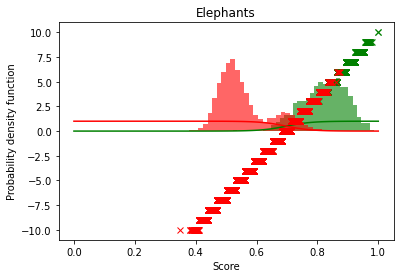

In [13]:
# exp_scorer = es.exp_scores.create_from_samples(
#             pos, neg
#         )
# gamma_scorer = gs.gamma_scores.create_from_samples(
#             pos, neg
#         )
# extexp_scorer = ees.extexp_scores.create_from_samples(
#             pos, neg
#         )
logistic_scorer = logistic_scores.logistic_scores.create_from_samples(
            pos, neg
        )

# def remove_outliers(scores, sign=1, std_mult=3):
#     # scores = np.array([s for (_, _, s) in pairs])
#     if sign < 0:
#         filter = scores - np.mean(scores) < std_mult * np.std(scores)
#     else:
#         filter = scores - np.mean(scores) > -std_mult * np.std(scores)
#     # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
#     return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

# pos1, pos_outliers = remove_outliers(pos_scores, 1)
# neg1, neg_outliers = remove_outliers(neg_scores, -1)

kernel_density_scorer = kernel_density_scores.create_from_samples(
    pos, neg
)
scorer = kernel_density_scorer
scorer = logistic_scorer
wgtr = weighter.weighter(scorer, lca_params['prob_human_correct'])

plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)


# Predict probabilities
# probabilities = model.predict_proba(xs)[:, 1]

# scorer = gamma_scorer
scorer = wgtr.scorer
pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]


plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')
# plt.title(title)
wgtr.max_weight = 10
pos_weights = [wgtr.wgt(x) for x in pos]
neg_weights = [wgtr.wgt(x) for x in neg]


def ratio(x):
    return x
#     # logger.info(f"Probability: {ratio}")
#     eps = 1e-8
#     wgt = np.log(ratio/(1-ratio + eps))
#     # logger.info(f"Weight: {wgt}")
#     return np.power(wgt, 3)
#     # return 10*(1/(1 + np.exp(-(x-0.5)))-0.5)

# pos_weights = [ratio(wgtr.scorer.get_prob(x)) for x in pos]
# neg_weights = [ratio(wgtr.scorer.get_prob(x)) for x in neg]
# pos_weights = [wgtr.scorer.raw_wgt_(x) for x in pos]
# neg_weights = [wgtr.scorer.raw_wgt_(x) for x in neg]


plt.plot(pos, pos_weights, "gx", label="Pos weights")
plt.plot(neg, neg_weights, "rx", label="Neg weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Elephants")

Text(0.5, 1.0, 'Sperm Whales')

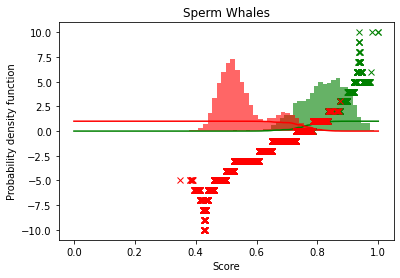

In [14]:
# exp_scorer = es.exp_scores.create_from_samples(
#             pos, neg
#         )
# gamma_scorer = gs.gamma_scores.create_from_samples(
#             pos, neg
#         )
# extexp_scorer = ees.extexp_scores.create_from_samples(
#             pos, neg
#         )
isotonic_scorer = isotonic_scores.isotonic_scores.create_from_samples(
            pos, neg
        )

# def remove_outliers(scores, sign=1, std_mult=3):
#     # scores = np.array([s for (_, _, s) in pairs])
#     if sign < 0:
#         filter = scores - np.mean(scores) < std_mult * np.std(scores)
#     else:
#         filter = scores - np.mean(scores) > -std_mult * np.std(scores)
#     # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
#     return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

# pos1, pos_outliers = remove_outliers(pos_scores, 1)
# neg1, neg_outliers = remove_outliers(neg_scores, -1)

kernel_density_scorer = kernel_density_scores.create_from_samples(
    pos, neg
)
scorer = kernel_density_scorer
scorer = isotonic_scorer
wgtr = weighter.weighter(scorer, lca_params['prob_human_correct'])

plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)


# Predict probabilities
# probabilities = model.predict_proba(xs)[:, 1]

# scorer = gamma_scorer
scorer = wgtr.scorer
pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]


plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')
# plt.title(title)
wgtr.max_weight = 10
pos_weights = [wgtr.wgt(x) for x in pos]
neg_weights = [wgtr.wgt(x) for x in neg]


def ratio(x):
    return x
#     # logger.info(f"Probability: {ratio}")
#     eps = 1e-8
#     wgt = np.log(ratio/(1-ratio + eps))
#     # logger.info(f"Weight: {wgt}")
#     return np.power(wgt, 3)
#     # return 10*(1/(1 + np.exp(-(x-0.5)))-0.5)

# pos_weights = [ratio(wgtr.scorer.get_prob(x)) for x in pos]
# neg_weights = [ratio(wgtr.scorer.get_prob(x)) for x in neg]
# pos_weights = [wgtr.scorer.raw_wgt_(x) for x in pos]
# neg_weights = [wgtr.scorer.raw_wgt_(x) for x in neg]


plt.plot(pos, pos_weights, "gx", label="Pos weights")
plt.plot(neg, neg_weights, "rx", label="Neg weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Sperm Whales")

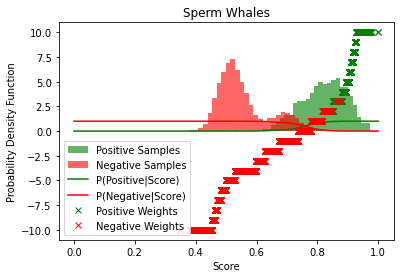

In [17]:
# Initialize Bayesian scorer with positive and negative samples
bayesian_scorer = bs.BayesianScores.create_from_samples(pos, neg)

# Use the Bayesian scorer in the weighter
scorer = bayesian_scorer
wgtr = weighter.weighter(scorer, lca_params['prob_human_correct'])

# Plot histograms of positive and negative scores
plt.hist(pos, bins=35, density=True, alpha=0.6, color='g', label="Positive Samples")
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r', label="Negative Samples")
xs = np.linspace(0, 1, 100)

# Predict probabilities for the range of scores
scorer = wgtr.scorer
pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]  # Probability of positive match
neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]  # Probability of negative match

# Plot the Bayesian probabilities
plt.plot(xs, pos_ys, color='g', label="P(Positive|Score)")
plt.plot(xs, neg_ys, color='r', label="P(Negative|Score)")
plt.legend()

# Set a max weight for visualization
wgtr.max_weight = 10
pos_weights = [wgtr.wgt(x) for x in pos]
neg_weights = [wgtr.wgt(x) for x in neg]

# Plot weights
plt.plot(pos, pos_weights, "gx", label="Positive Weights")
plt.plot(neg, neg_weights, "rx", label="Negative Weights")

# Set plot labels and title
plt.xlabel("Score")
plt.ylabel("Probability Density Function")
plt.title("Sperm Whales")
plt.legend()
plt.show()

In [81]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel, Matern


X = np.concatenate([pos_scores, neg_scores]).reshape(-1, 1)
y = np.concatenate([np.ones((len(pos_scores),)), np.zeros((len(neg_scores),))])

# X = np.concatenate([pos, neg]).reshape(-1, 1)
# y = np.concatenate([np.ones((len(pos),)), np.zeros((len(neg),))])

kernel = 1.0 * RBF(1)
# kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1, alpha_bounds=(1e-5, 1e15))
# kernel = 1.0 * ExpSineSquared(
#     length_scale=1.0,
#     periodicity=3.0,
#     length_scale_bounds=(0.1, 10.0),
#     periodicity_bounds=(1.0, 10.0),
# )
# kernel = (
#     DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2
# )
# kernel = 1.0 * RBF(1)
# kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)
gpc.score(X, y)

# gpc.predict_proba(X[:2,:])


0.8292079207920792

In [82]:
# gpc.predict_proba(X.reshape(1, -1)[:, 0:1])

Text(0.5, 1.0, 'Elephants')

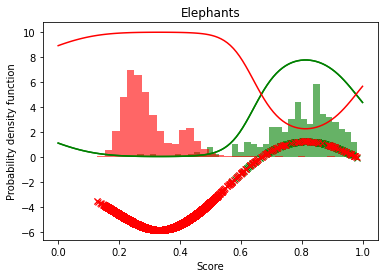

In [83]:
plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)

pos_ys = 10*gpc.predict_proba(xs.reshape(-1, 1))[:, 1]
neg_ys = 10*gpc.predict_proba(xs.reshape(-1, 1))[:, 0]

eps = 1e-12
pos_s = gpc.predict_proba(np.array(pos).reshape(-1, 1))[:, 1] 
neg_s = gpc.predict_proba(np.array(neg).reshape(-1, 1))[:, 1] 
pos_wgts = np.log(pos_s/(1-pos_s + eps))
neg_wgts = np.log(neg_s/(1-neg_s + eps))
plt.plot(pos, pos_wgts, "gx", label="Pos weights")
plt.plot(neg, neg_wgts, "rx", label="Neg weights")


plt.plot(xs, pos_ys, color='g')

plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')

# plt.plot(pos, pos_weights, "gx", label="Pos weights")
# plt.plot(neg, neg_weights, "rx", label="Neg weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Elephants")

In [84]:
gp, gp_err = gpc.predict(xs, return_std=True)

TypeError: predict() got an unexpected keyword argument 'return_std'

GaussianProcessRegressor()

In [ ]:
# %load_ext autoreload
# %autoreload 2
# from preprocess import preprocess_data
# from embeddings import Embeddings
# from curate_using_LCA import curate_using_LCA, generate_wgtr_calibration_ground_truth
# from tools import *
# import random
# import os
# from cluster_validator import ClusterValidator

# lca_config = config['lca']
# data_params = config['data']
# lca_params = generate_ga_params(lca_config)

# embeddings, uuids = load_pickle(data_params['embedding_file'])

# #create db files

# db_path = os.path.join(lca_config['db_path'], config['exp_name'])
# os.makedirs(db_path, exist_ok=True)

# verifier_file =  os.path.join(db_path, "verifiers_probs.json")
# edge_db_file =  os.path.join(db_path, "quads.csv")
# clustering_file = os.path.join(db_path, "clustering.json")
# autosave_file = os.path.join(db_path, "autosave.json")

# lca_params['autosave_file'] = autosave_file


# # preprocess data

# name_keys = data_params['name_keys']
# filter_key = '__'.join(name_keys)
# df = preprocess_data(data_params['annotation_file'], 
#                     name_keys= name_keys,
#                     convert_names_to_ids=True, 
#                     viewpoint_list=data_params['viewpoint_list'], 
#                     n_filter_min=data_params['n_filter_min'], 
#                     n_filter_max=data_params['n_filter_max'],
#                     images_dir = data_params['images_dir'], 
#                     embedding_uuids = uuids
#                 )

# print_intersect_stats(df, individual_key=filter_key)


# # create cluster validator
# filtered_df = df[df['uuid_x'].isin(uuids)]
# embeddings = [embeddings[uuids.index(uuid)] for uuid in filtered_df['uuid_x']]
# gt_clustering, gt_node2cid, node2uuid = generate_gt_clusters(filtered_df, filter_key)
# cluster_validator = ClusterValidator(gt_clustering, gt_node2cid)
# ga_driver.set_validator_functions(cluster_validator.trace_start_human, cluster_validator.trace_iter_compare_to_gt)


# # create embeddings verifier
# print(len(node2uuid.keys()))
# print(len(embeddings))
# verifier_embeddings = Embeddings(embeddings, list(node2uuid.keys()), distance_power=lca_params['distance_power'])
# verifier_edges = verifier_embeddings.get_edges()

# # create human reviewer

# prob_human_correct = lca_params['prob_human_correct']
    
# human_reviewer = call_get_reviews(df, filter_key, prob_human_correct)
# num_pos_needed = lca_params['num_pos_needed']
# num_neg_needed = lca_params['num_neg_needed']


# pos, neg, quit = generate_wgtr_calibration_ground_truth(verifier_edges, human_reviewer, num_pos_needed, num_neg_needed)

# pos_scores = [s for (_, _, s) in pos]
# neg_scores = [s for (_, _, s) in neg]

# scorer = es.exp_scores.create_from_samples(
#             pos_scores, neg_scores
#         )

In [ ]:
# pos_scores_all = []
# neg_scores_all = []
# edge_nodes = [(n1, n2) for (n1, n2, _) in verifier_edges]
# i = 0
# print("getting reviews")
# reviews, quit_lca = human_reviewer(edge_nodes)
# print("got")
# for ((_, _, b), (_, _, s)) in zip(reviews, verifier_edges):
#     if b:
#         pos_scores_all.append(s)
#     else:
#         neg_scores_all.append(s)
# print("fin")

In [ ]:
# all_scores = [s for (_, _, s) in verifier_edges]

# plt.hist(all_scores, bins=35, density=True, alpha=0.6, color='g')

# plt.hist(pos_scores_all, bins=35, density=True, alpha=0.6, color='g')
# plt.hist(neg_scores_all, bins=35, density=True, alpha=0.6, color='r')

In [ ]:
from sklearn.linear_model import LogisticRegression

Text(0.5, 1.0, 'Elephants')

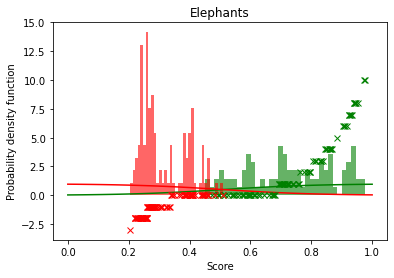

In [ ]:
def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad

# def remove_outliers(scores, std_mult=5):
#     # scores = np.array([s for (_, _, s) in pairs])
#     # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
#     median = np.median(scores)
#     mad = np.median(np.abs(scores-median))
#     filter = scores - median < std_mult * mad
#     return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

def remove_outliers(scores, sign=1, std_mult=1.5):
    # scores = np.array([s for (_, _, s) in pairs])
    if sign < 0:
        filter = scores - np.mean(scores) < std_mult * np.std(scores)
    else:
        filter = scores - np.mean(scores) > -std_mult * np.std(scores)
    # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
    return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

pos, pos_outliers = remove_outliers(pos_scores, 1)
neg, neg_outliers = remove_outliers(neg_scores, -1)
            # outliers = np.concatenate((pos_outliers, neg_outliers))
            # logger.info(f"Len before filtering: {len(verifier_edges)}")
            # verifier_edges = [edge for edge in verifier_edges if edge not in outliers]
            # logger.info(f"Len after filtering: {len(verifier_edges)}")
pos = pos_scores
neg = neg_scores


exp_scorer = es.exp_scores.create_from_samples(
            pos, neg
        )
gamma_scorer = gs.gamma_scores.create_from_samples(
            pos, neg
        )
extexp_scorer = ees.extexp_scores.create_from_samples(
            pos, neg
        )
logistic_scorer = logistic_scores.logistic_scores.create_from_samples(
            pos, neg
        )

plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)
scorer = logistic_scorer
wgtr = weighter.weighter(scorer, lca_params['prob_human_correct'])


# Predict probabilities
# probabilities = model.predict_proba(xs)[:, 1]

# scorer = gamma_scorer
pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]


plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')
# plt.title(title)
wgtr.max_weight = 10
pos_weights = [wgtr.wgt(x) for x in pos]
neg_weights = [wgtr.wgt(x) for x in neg]

plt.plot(pos, pos_weights, "gx", label="Pos weights")
plt.plot(neg, neg_weights, "rx", label="Neg weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Elephants")
# plt.legend(["Positive scores", "Negative scores", "Estimated positive", "Estimated negative", "Pos weights", "Neg weights"])

Text(0.5, 1.0, 'Elephants')

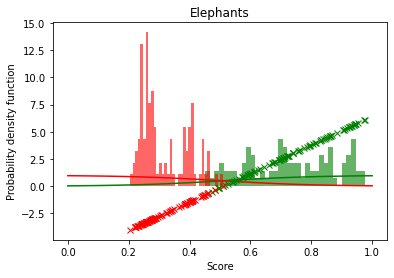

In [ ]:
def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad

# def remove_outliers(scores, std_mult=5):
#     # scores = np.array([s for (_, _, s) in pairs])
#     # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
#     median = np.median(scores)
#     mad = np.median(np.abs(scores-median))
#     filter = scores - median < std_mult * mad
#     return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

def remove_outliers(scores, sign=1, std_mult=1.5):
    # scores = np.array([s for (_, _, s) in pairs])
    if sign < 0:
        filter = scores - np.mean(scores) < std_mult * np.std(scores)
    else:
        filter = scores - np.mean(scores) > -std_mult * np.std(scores)
    # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
    return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

pos, pos_outliers = remove_outliers(pos_scores, 1)
neg, neg_outliers = remove_outliers(neg_scores, -1)
            # outliers = np.concatenate((pos_outliers, neg_outliers))
            # logger.info(f"Len before filtering: {len(verifier_edges)}")
            # verifier_edges = [edge for edge in verifier_edges if edge not in outliers]
            # logger.info(f"Len after filtering: {len(verifier_edges)}")
pos = pos_scores
neg = neg_scores


exp_scorer = es.exp_scores.create_from_samples(
            pos, neg
        )
gamma_scorer = gs.gamma_scores.create_from_samples(
            pos, neg
        )
extexp_scorer = ees.extexp_scores.create_from_samples(
            pos, neg
        )

plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)
scorer = extexp_scorer
wgtr = weighter.weighter(exp_scorer, lca_params['prob_human_correct'])

X = np.concatenate((pos, neg))
y = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))))
model = LogisticRegression(class_weight="balanced")

model.fit(X.reshape(-1, 1), y)

# Predict probabilities
# probabilities = model.predict_proba(xs)[:, 1]

# scorer = gamma_scorer
# pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
# neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]
pos_ys = model.predict_proba(xs.reshape(-1, 1))[:, 1]
neg_ys = model.predict_proba(xs.reshape(-1, 1))[:, 0]


plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')
# plt.title(title)
wgtr.max_weight = 10
# pos_weights = [wgtr.wgt(x) for x in pos]
# neg_weights = [wgtr.wgt(x) for x in neg]

def to_weight(ratio):
    eps = 1e-8
    return np.log(ratio/(1-ratio + eps))

pos_weights = to_weight(model.predict_proba(np.array(pos).reshape(-1, 1))[:, 1])
neg_weights = to_weight(model.predict_proba(np.array(neg).reshape(-1, 1))[:, 1])

plt.plot(pos, pos_weights*2, "gx", label="Pos weights")
plt.plot(neg, neg_weights*2, "rx", label="Neg weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Elephants")
# plt.legend(["Positive scores", "Negative scores", "Estimated positive", "Estimated negative", "Pos weights", "Neg weights"])

Text(0.5, 1.0, 'Elephants')

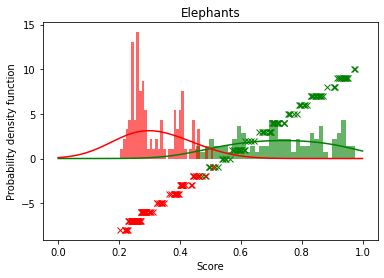

In [ ]:
from kernel_density_scores import kernel_density_scores

def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad

# def remove_outliers(scores, std_mult=5):
#     # scores = np.array([s for (_, _, s) in pairs])
#     # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
#     median = np.median(scores)
#     mad = np.median(np.abs(scores-median))
#     filter = scores - median < std_mult * mad
#     return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

def remove_outliers(scores, sign=1, std_mult=1.5):
    # scores = np.array([s for (_, _, s) in pairs])
    if sign < 0:
        filter = scores - np.mean(scores) < std_mult * np.std(scores)
    else:
        filter = scores - np.mean(scores) > -std_mult * np.std(scores)
    # filter = np.abs(scores - np.mean(scores)) < std_mult * np.std(scores)
    return np.array(scores)[filter], np.array(scores)[np.logical_not(filter)]

pos, pos_outliers = remove_outliers(pos_scores, 1)
neg, neg_outliers = remove_outliers(neg_scores, -1)
            # outliers = np.concatenate((pos_outliers, neg_outliers))
            # logger.info(f"Len before filtering: {len(verifier_edges)}")
            # verifier_edges = [edge for edge in verifier_edges if edge not in outliers]
            # logger.info(f"Len after filtering: {len(verifier_edges)}")
pos = pos_scores
neg = neg_scores


exp_scorer = es.exp_scores.create_from_samples(
            pos, neg
        )
gamma_scorer = gs.gamma_scores.create_from_samples(
            pos, neg
        )
extexp_scorer = ees.extexp_scores.create_from_samples(
            pos, neg
        )
kernel_density_scorer = kernel_density_scores.create_from_samples(
    pos, neg
)

plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
xs = np.linspace(0, 1, 100)
scorer = kernel_density_scorer
wgtr = weighter.weighter(exp_scorer, lca_params['prob_human_correct'])

pos_ys = [scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [scorer.get_pos_neg(x)[1] for x in xs]


plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')
# plt.title(title)
wgtr.max_weight = 10
pos_weights = [wgtr.wgt(x) for x in pos]
neg_weights = [wgtr.wgt(x) for x in neg]

# def to_weight(ratio):
#     eps = 1e-8
#     return np.log(ratio/(1-ratio + eps))

# pos_weights = to_weight(model.predict_proba(np.array(pos).reshape(-1, 1))[:, 1])
# neg_weights = to_weight(model.predict_proba(np.array(neg).reshape(-1, 1))[:, 1])

plt.plot(pos, pos_weights, "gx", label="Pos weights")
plt.plot(neg, neg_weights, "rx", label="Neg weights")

plt.xlabel("Score")
plt.ylabel("Probability density function")
plt.title("Elephants")
# plt.legend(["Positive scores", "Negative scores", "Estimated positive", "Estimated negative", "Pos weights", "Neg weights"])

In [ ]:
len(pos)

88

In [ ]:
len(neg)

62

In [ ]:
scorer.truncexp_neg

Truncated exponential distribution(loc=0.0, scale=0.3552706914563333, is_positive=False)

In [ ]:
np.median(neg_scores)

0.28706690669059753